Code to generate a combined annData file for plate 7,8,9 tested with erlotinib

Two different anndata objects will be created - for DMSO and for erlotinib

In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
data_path = '../data/tahoe_data'
data_files = [f'plate{i}_annData.h5ad' for i in range(7,10,1)]
print(data_files)

['plate7_annData.h5ad', 'plate8_annData.h5ad', 'plate9_annData.h5ad']


In [3]:
import gc

In [7]:
# create a merged annData file for DMSO and erlotinib separately
dmso_adatas = []
erlotinib_adatas = []

for data_file in data_files:
    file_path = os.path.join(data_path, data_file)
    plate_adata = sc.read_h5ad(file_path, backed='r')
    batch_id = data_file.replace('.h5ad', '')
    # Create a boolean mask for DMSO cells
    dmso_mask = plate_adata.obs['drug'] == 'DMSO_TF'

    # Check if any DMSO cells exist in this file
    if dmso_mask.any():
        # OPTIMIZATION 2: Create a view of only the DMSO cells
        dmso_view = plate_adata[dmso_mask, :]

        # OPTIMIZATION 3: Load *only the view* into memory as a new object
        dmso_slice = dmso_view.to_memory()

        # BEST PRACTICE: Add a batch column for provenance
        dmso_slice.obs['batch'] = batch_id

        dmso_adatas.append(dmso_slice)
        print(
            f"  > Found and extracted {dmso_slice.n_obs} DMSO cells from {batch_id}.")
        # Clean up the in-memory slice object reference from the view
        del dmso_view, dmso_slice
    else:
        print("  > No DMSO cells found in this file.")

        # --- Process Erlotinib data (same logic) ---
    erlotinib_mask = plate_adata.obs['drug'] == 'Erlotinib'

    if erlotinib_mask.any():
        erlotinib_view = plate_adata[erlotinib_mask, :]
        erlotinib_slice = erlotinib_view.to_memory()
        erlotinib_slice.obs['batch'] = batch_id
        erlotinib_adatas.append(erlotinib_slice)
        print(
            f"  > Found and extracted {erlotinib_slice.n_obs} Erlotinib cells from {batch_id}.")
        del erlotinib_view, erlotinib_slice
    else:
        print("  > No Erlotinib cells found in this file.")

    del plate_adata
    gc.collect()  # Force garbage collection to reclaim memory immediately

  > Found and extracted 101543 DMSO cells from plate7_annData.
  > Found and extracted 86752 Erlotinib cells from plate7_annData.
  > Found and extracted 205745 DMSO cells from plate8_annData.
  > Found and extracted 129042 Erlotinib cells from plate8_annData.
  > Found and extracted 132211 DMSO cells from plate9_annData.
  > Found and extracted 47066 Erlotinib cells from plate9_annData.


In [8]:
len(dmso_adatas)

3

In [9]:
len(erlotinib_adatas)

3

In [10]:
dmso_merged = sc.concat(dmso_adatas)
drug_merged = sc.concat(erlotinib_adatas)

In [11]:
dmso_merged

AnnData object with n_obs × n_vars = 439499 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'batch'

In [12]:
drug_merged

AnnData object with n_obs × n_vars = 262860 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'batch'

In [13]:
dmso_merged.write_h5ad('dmso_merged_raw_aData.h5ad', compression = 'gzip')
drug_merged.write_h5ad('erlotinib_merged_raw_aData.h5ad', compression = 'gzip')

USE DMSO adata and omicverse preprocessing to create clean adata without batch effects

In [14]:
import omicverse as ov

/home/sreeramp/miniforge3/envs/omicverse/lib/python3.10/site-packages/omicverse/utils/_data.py:329: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


#### Preprocessing and metacells for DMSO

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
dmso_merged

AnnData object with n_obs × n_vars = 439499 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'batch'

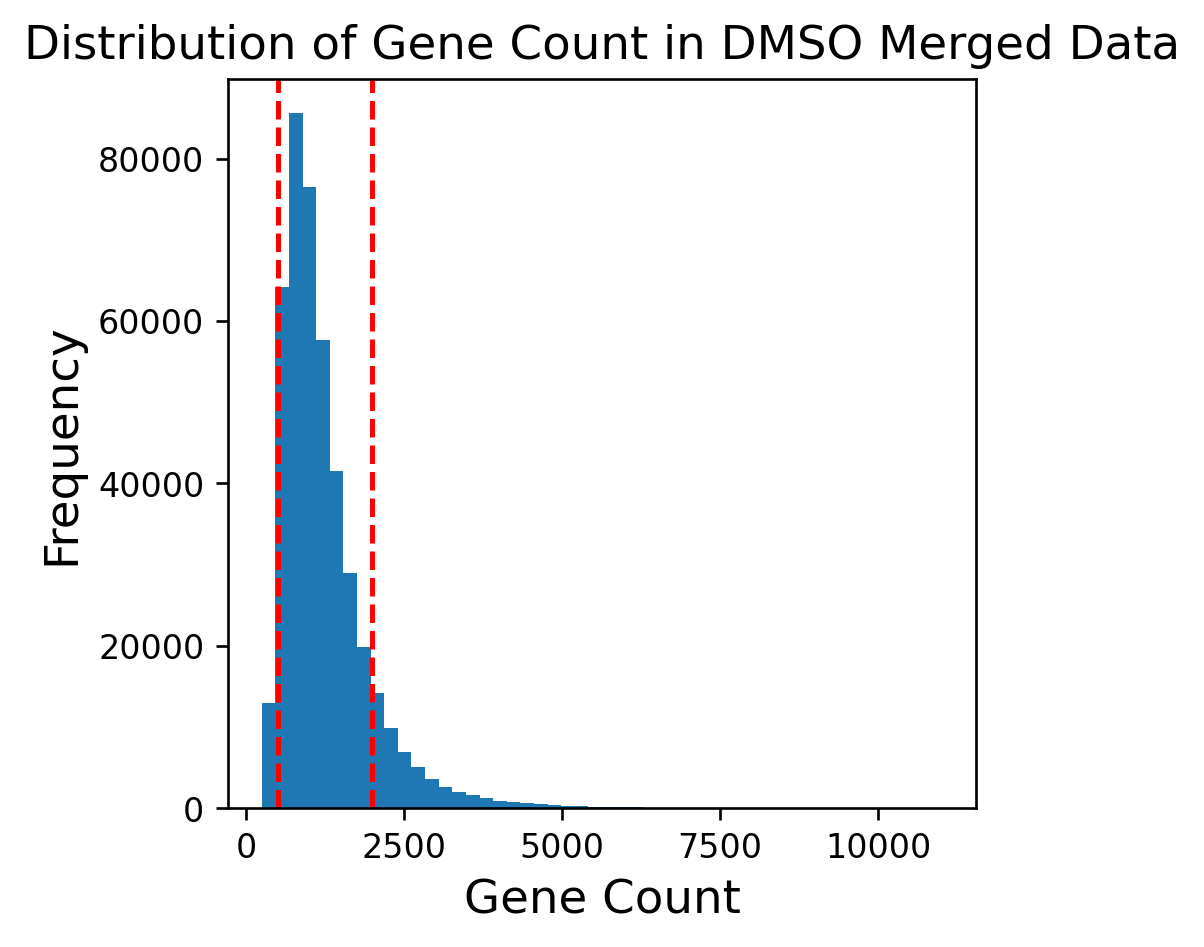

In [32]:
plt.hist(dmso_merged.obs['gene_count'], bins=50)
plt.axvline(x=500, color='red', linestyle='--')
plt.axvline(x=2000, color='red', linestyle='--')
plt.xlabel('Gene Count')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Count in DMSO Merged Data')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.grid(False)
plt.show()

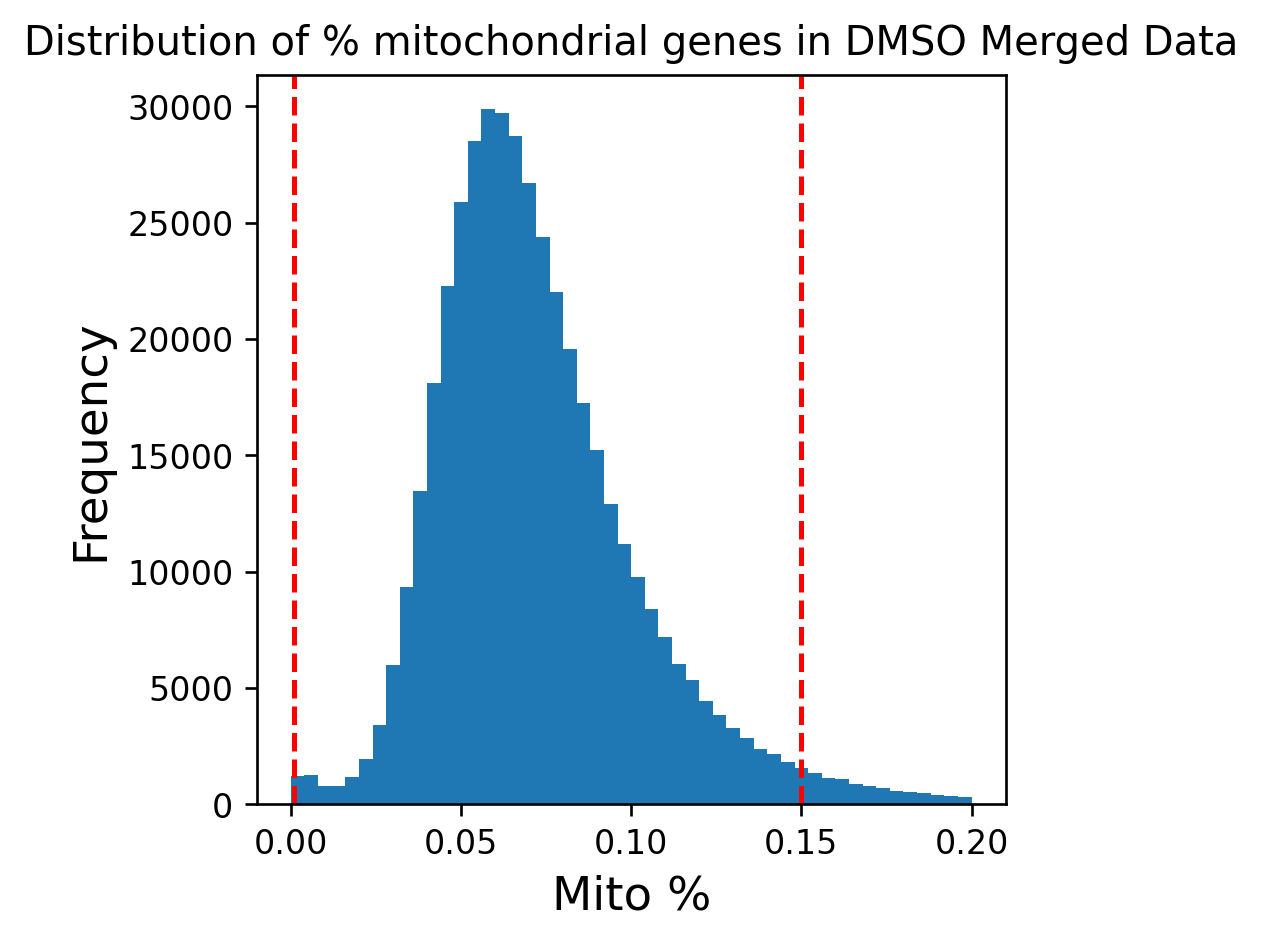

In [35]:
plt.hist(dmso_merged.obs['pcnt_mito'], bins=50)
plt.axvline(x=0.15, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Mito %')
plt.ylabel('Frequency')
plt.title('Distribution of % mitochondrial genes in DMSO Merged Data', fontsize=12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.grid(False)
# plt.legend()
plt.show()

In [40]:
pd.crosstab(dmso_merged.obs['batch'], dmso_merged.obs['pass_filter'])

pass_filter,full,minimal
batch,,
plate7_annData,88033,13510
plate8_annData,197472,8273
plate9_annData,117844,14367


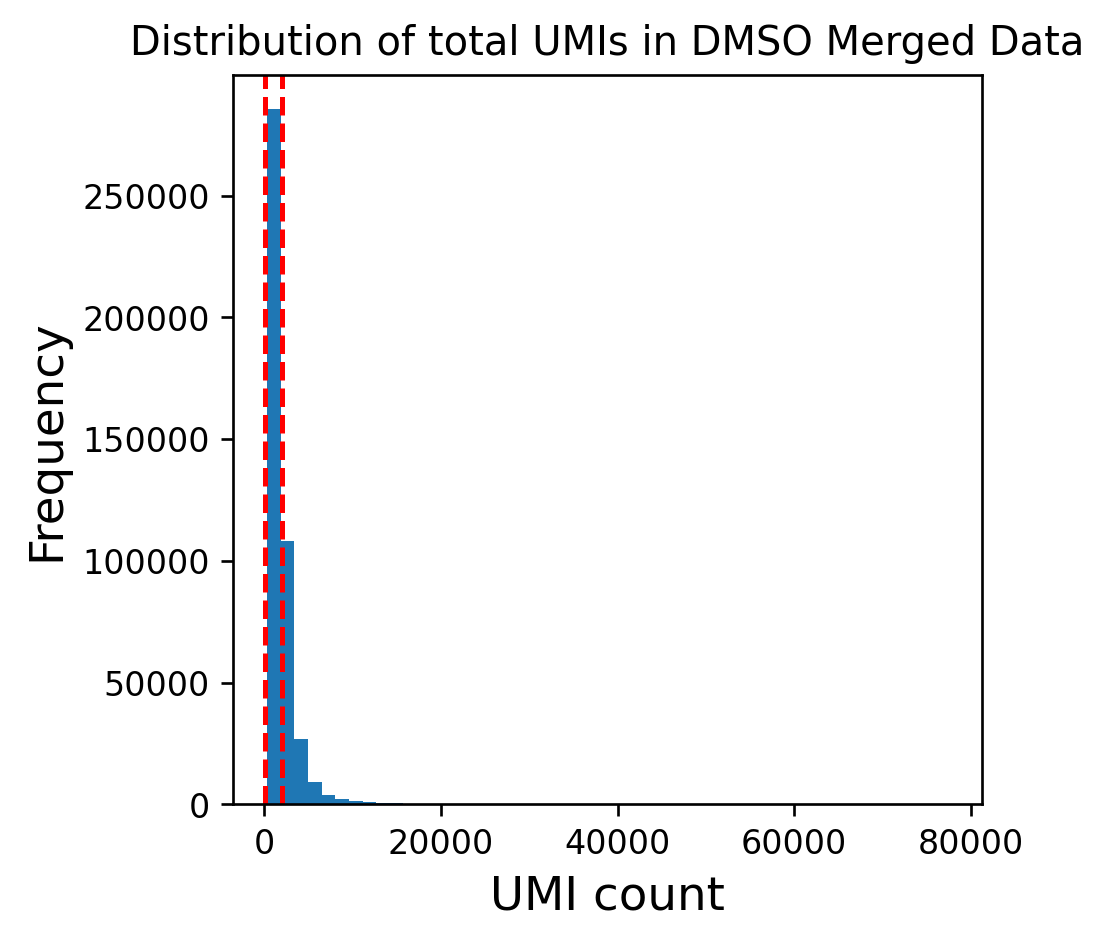

In [39]:
plt.hist(dmso_merged.obs['tscp_count'], bins=50)
plt.axvline(x=50, color='red', linestyle='--')
plt.axvline(x=2000, color='red', linestyle='--')
plt.xlabel('UMI count')
plt.ylabel('Frequency')
plt.title('Distribution of total UMIs in DMSO Merged Data', fontsize=12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.grid(False)
# plt.legend()
plt.show()

In [41]:
dmso_clean = ov.pp.qc(dmso_merged,
              tresh={'pass_filter': 'full'},
               doublets_method='sccomposite',
              batch_key='batch')

🖥️ Using torch CPU mode...
Calculate QC metrics
End calculation of QC metrics.
Original cell number: 439499
!!!It should be noted that the `sccomposite` will remove more cells than             `scrublet`!!!
Begin of post doublets removal and QC plot using `sccomposite`
Cuda is not available; Fitting the COMPOSITE model on RNA modality


KeyboardInterrupt: 